In [1]:
import torch
import itertools
import numpy as np
import time

from agents.infotaxis import Infotaxis
from env import GridEnvDeform, POMDPWrapper_v1, create_maze


In [2]:
O = torch.load('./models/O_maze_2.pt', weights_only=True)
T = torch.load('./models/T_maze_2.pt', weights_only=True)
R = torch.load('./models/R_maze_2.pt', weights_only=True)

Infotaxis = Infotaxis(T,O,R)

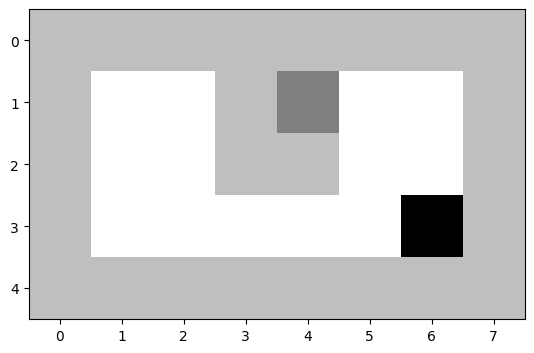

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [3]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")


In [4]:
env_wrapper = POMDPWrapper_v1(env, T,O,R)

Initial state:  ((3, 4, 3), (2, 1))


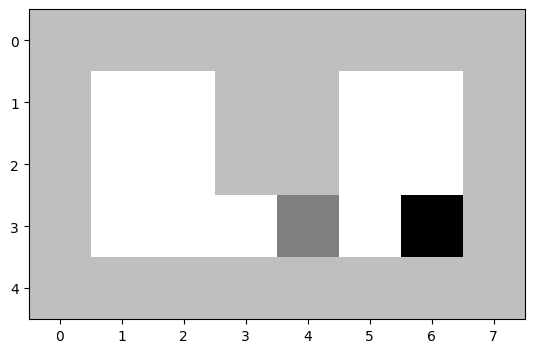

Best action:  0
state 127


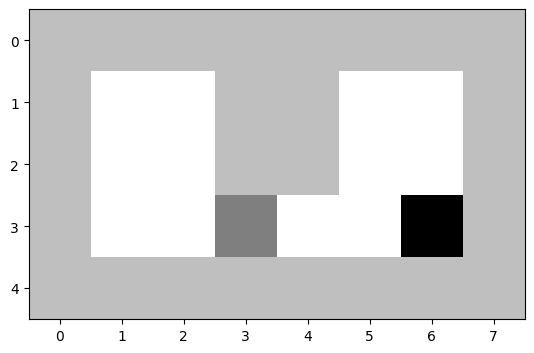

Step:  9
Timestep missing: 9  
Total reward:     -0.5  
Chosen action:  0
Actual State:  ((3, 3, 3), (2, 1))
argmax and max Belief:  ((1, 2, 1), (1, 1)) tensor(0.1667)
Belief entropy:  2.5849623680114746
Best action:  1
state 119


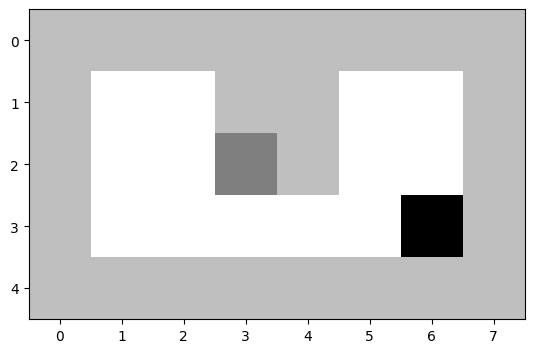

Step:  8
Timestep missing: 8  
Total reward:     -2.5  
Chosen action:  1
Actual State:  ((2, 3, 0), (2, 1))
argmax and max Belief:  ((2, 3, 0), (2, 1)) tensor(0.5000)
Belief entropy:  1.0
Best action:  1
state 65


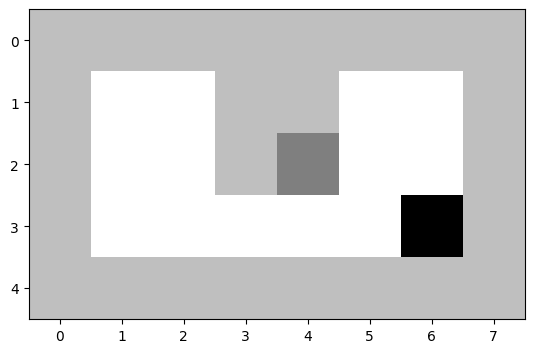

Step:  7
Timestep missing: 7  
Total reward:     -4.5  
Chosen action:  1
Actual State:  ((2, 4, 1), (2, 1))
argmax and max Belief:  ((2, 4, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 75


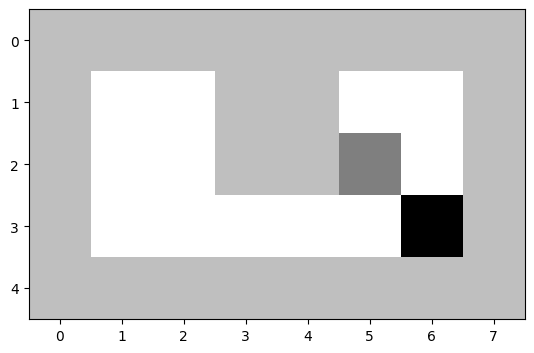

Step:  6
Timestep missing: 6  
Total reward:     -5.0  
Chosen action:  0
Actual State:  ((2, 5, 1), (2, 1))
argmax and max Belief:  ((2, 5, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 83


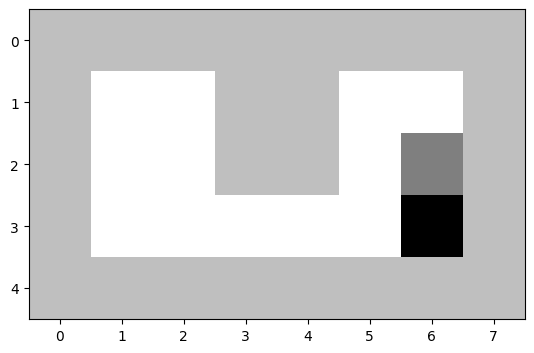

Step:  5
Timestep missing: 5  
Total reward:     -5.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


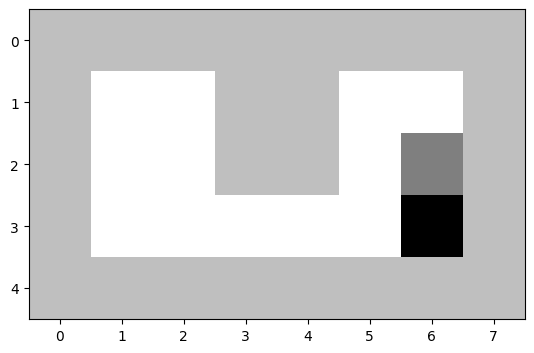

Step:  4
Timestep missing: 4  
Total reward:     -6.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


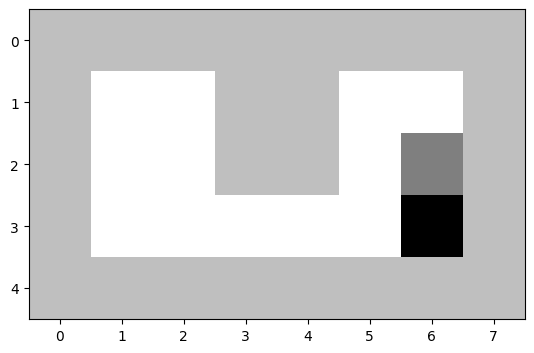

Step:  3
Timestep missing: 3  
Total reward:     -7.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


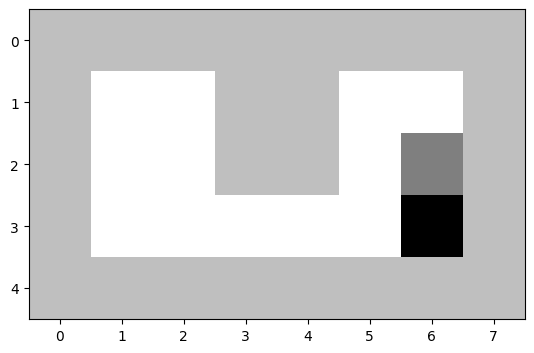

Step:  2
Timestep missing: 2  
Total reward:     -8.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


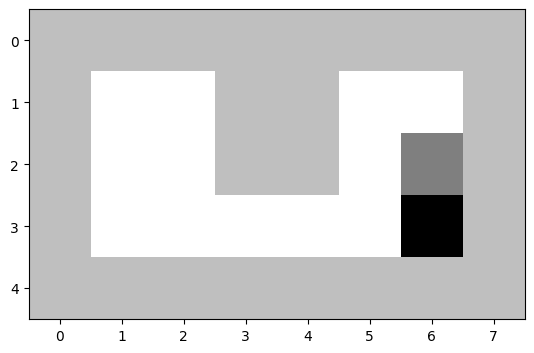

Step:  1
Timestep missing: 1  
Total reward:     -9.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


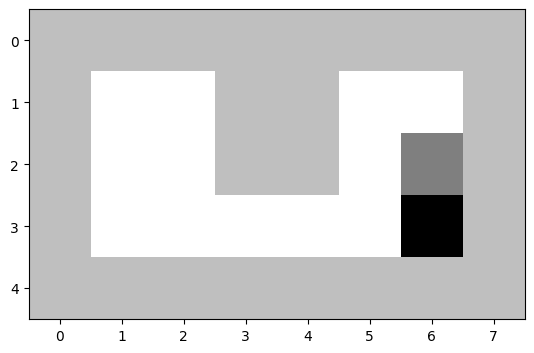

Step:  0
Timestep missing: 0  
Total reward:     -10.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0


In [5]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))

print("Initial state: ", states[s])
env.render(states[s])

horizon = 10
totalReward = 0.0

for t in range(horizon - 1, -1, -1):

    best_action = Infotaxis.get_action(b)

    #best_action = np.random.choice([0,1,2,3])
    print("Best action: ", best_action)
    print("state", s)
    next_obs, reward, done, info = env_wrapper.step(s, best_action)
    
    next_state = info['actual_state']
    env.render(states[next_state])



    totalReward += reward
    next_belief = Infotaxis.update_belief(b, best_action, next_obs)
    
    print("Step: ", t)
    print("Timestep missing: " + str(t) + "  ") # Print space after to clear
    print("Total reward:     " + str(totalReward) + "  ")
    print("Chosen action: ", best_action)

    print("Actual State: ", states[next_state])
    print("argmax and max Belief: ", states[torch.argmax(next_belief)], torch.max(next_belief))
    print("Belief entropy: ", Infotaxis.get_entropy(next_belief))

    if t == 1:
        assert states[torch.argmax(next_belief)] == states[next_state] 
    
    # Then we update the world
    s = next_state
    b = next_belief
    # Sleep 1 second so the user can see what is happening.
    time.sleep(1)



In [8]:
b = torch.rand(10)
print(b)
torch.exp(b)

tensor([0.3686, 0.7249, 0.5607, 0.8371, 0.8711, 0.7325, 0.8298, 0.5433, 0.8754,
        0.2942])


tensor([1.4457, 2.0644, 1.7518, 2.3096, 2.3895, 2.0803, 2.2929, 1.7216, 2.3998,
        1.3420])